Dataset Link: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset/data

**Importing the Dependencies**

In [2]:
import os
import json

import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
df = pd.read_csv("spotify_millsongdata.csv")

**Initial Understanding**

In [6]:
df.shape

(57650, 4)

In [7]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [9]:
df.isnull().sum()

artist    0
song      0
link      0
text      0
dtype: int64

In [10]:
# Top artists and songs
top_artists = df['artist'].value_counts().head(10)
print("\nTop 10 Artists:")
print(top_artists)


Top 10 Artists:
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [11]:
df = df.sample(10000)

df = df.drop('link', axis=1).reset_index(drop=True)

In [12]:
df.shape

(10000, 3)

In [13]:
df.head()

,artist,song,text
0,Bob Seger,Tightrope,Saw you walkin' on a backstreet honey \r\nTry...
1,Foo Fighters,Ffl,Ready aim fire \r\nNo one fuckin' around stan...
2,Nine Inch Nails,God Given,"Hey, man, please don't make a sound \r\nTake ..."
3,Aerosmith,Falling In Love (Is Hard On Your Knees),Falling In Love \r\n(Is Hard On The Knees) \...
4,Glee,And I Am Telling You I'm Not Going Lyrics,And I am telling you \r\nI'm not going \r\nY...


In [14]:
# WordCloud for song lyrics
all_lyrics = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_lyrics)

WordCloud to visualize the most common words in the lyrics.

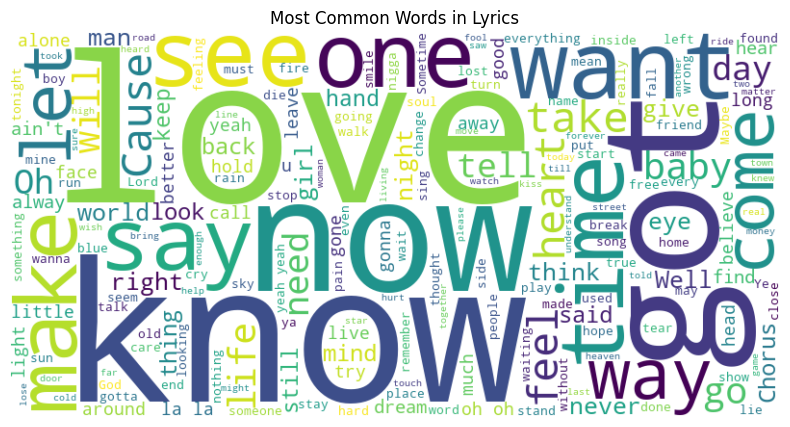

In [15]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Lyrics")
plt.show()

**Data Preprocessing**

In [16]:
# download nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\singh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\singh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\singh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [17]:
stop_words = set(stopwords.words('english'))

In [18]:
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [19]:
# Apply preprocessing to lyrics
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [20]:
df.head()

,artist,song,text,cleaned_text
0,Bob Seger,Tightrope,Saw you walkin' on a backstreet honey \r\nTry...,saw walkin backstreet honey tryin slip away fi...
1,Foo Fighters,Ffl,Ready aim fire \r\nNo one fuckin' around stan...,ready aim fire one fuckin around standing line...
2,Nine Inch Nails,God Given,"Hey, man, please don't make a sound \r\nTake ...",hey man please dont make sound take look aroun...
3,Aerosmith,Falling In Love (Is Hard On Your Knees),Falling In Love \r\n(Is Hard On The Knees) \...,falling love hard knees one two three four zum...
4,Glee,And I Am Telling You I'm Not Going Lyrics,And I am telling you \r\nI'm not going \r\nY...,telling im going youre best man ill ever know ...


In [21]:
# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [22]:
# Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [23]:
# Recommendation Function
def recommend_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
    # Find the index of the song
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset!"   # can be reworked to compare for songs not present in the dataset
    idx = idx[0]

    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # Get song indices
    song_indices = [i[0] for i in sim_scores]

    # Return top n similar songs
    return df[['artist', 'song']].iloc[song_indices]

In [24]:
df["song"][2]

'God Given'

In [25]:
# Example Recommendation
print("\nRecommendations for the song 'Blinded By Rainbows':")
recommendations = recommend_songs("God Given") # df["song"][2]
print(recommendations)


Recommendations for the song 'Blinded By Rainbows':
              artist                song
6015   Wanda Jackson      Right Or Wrong
3131      Kanye West          See Me Now
2873      Chaka Khan      Right Is Right
4812  Point Of Grace  More Than Anything
5465   Kirk Franklin            I Am God
